Imports
============

In [26]:
import sys
sys.path.append('/home/dhaval/PycharmProjects/DeepVesselNet/dvn')
from data_utils import SyntheticData
import numpy as np
import matplotlib.pyplot as plt
import torch
from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
import dvn.misc as ms
import nibabel as nib
import os


Firstly we load the data
============
Update 04.12.19: Updated dataloader with SyntheticData
                    Patches?


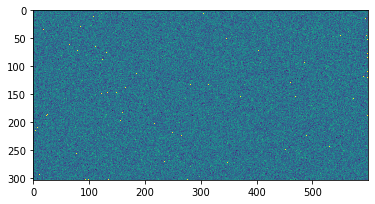

In [61]:
synthetic = SyntheticData(root_path = "./data/")


Visualize part of the data
============

Design network 
============

Train network
============

Test network
============

Visualization of network outputs
============
